Notebook Credit to Harshit Trehan.
Notebook provided by Dr.Fabio Di Troia for use in this project

The code was modified by Albert Giang to incorporate training epoch and to be compatible to a new folder structure

This Notebook contains the architecture of the WGAN-GP and functions to train the model on each of the malware families



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!cp /content/drive/MyDrive/CMPE_295/Data/malware_data.zip .
!unzip malware_data.zip
!rm malware_data.zip
!rm -rf /content/__MACOSX

Streaming output truncated to the last 5000 lines.
  inflating: WinWebSec/fb1ef23c9dcb41e4e695b0f77006002e13397f1f.asm.txt  
  inflating: __MACOSX/WinWebSec/._fb1ef23c9dcb41e4e695b0f77006002e13397f1f.asm.txt  
  inflating: WinWebSec/fa8e99c81737f1a3f8d667bff7242f201e6b3ecb.asm.txt  
  inflating: __MACOSX/WinWebSec/._fa8e99c81737f1a3f8d667bff7242f201e6b3ecb.asm.txt  
  inflating: WinWebSec/1afc2a2036812279c58de0b825ebdea423341182.asm.txt  
  inflating: __MACOSX/WinWebSec/._1afc2a2036812279c58de0b825ebdea423341182.asm.txt  
  inflating: WinWebSec/535f05c124a21b5d1746ac7c1d36ed7df3eeb260.asm.txt  
  inflating: __MACOSX/WinWebSec/._535f05c124a21b5d1746ac7c1d36ed7df3eeb260.asm.txt  
  inflating: WinWebSec/b77d8d8fc75ecf193af4e90ab559bc54f2bd38b6.asm.txt  
  inflating: __MACOSX/WinWebSec/._b77d8d8fc75ecf193af4e90ab559bc54f2bd38b6.asm.txt  
  inflating: WinWebSec/008883bab2c8e1f32d03707abd5dc7650c813615.asm.txt  
  inflating: __MACOSX/WinWebSec/._008883bab2c8e1f32d03707abd5dc7650c813615.asm.t

# New Section

In [3]:
!cp /content/drive/MyDrive/CMPE_295/Data/data.py .
!cp /content/drive/MyDrive/CMPE_295/Data/opdictWinWebSec.json .
!cp /content/drive/MyDrive/CMPE_295/Data/opdictZbot.json .
!cp /content/drive/MyDrive/CMPE_295/Data/opdictVBInject.json .
!cp /content/drive/MyDrive/CMPE_295/Data/opdictOnLineGames.json .
!cp /content/drive/MyDrive/CMPE_295/Data/opdictRenos.json .

In [1]:
from __future__ import print_function, division

import tensorflow
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv1D
from tensorflow.keras.layers import BatchNormalization, Activation, LayerNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers.legacy import RMSprop, Adam
from functools import partial
from tensorflow.keras.utils import plot_model

import keras.backend as K
import matplotlib.pyplot as plt
import sys
import numpy as np
import glob
import json
from random import sample
import math

import data

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [2]:
class RandomWeightedAverage(Add):
    'Weighted average between real and fake samples'
    def _merge_function(self, inputs):
        alpha = K.random_uniform((32, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

In [3]:
class WGANGP():
    def __init__(self, family, num_unique, n_critic, alpha, beta_1, beta_2, adam):
        """
        @params:
        family: malware family
        num_unique: number of unique opcodes (used to rescale the data samples between -1 and 1)
        n_critic: critic iterations per generator iteration
        alpha: Adam learning rate
        beta_1, beta_2: Adam 1st and 2nd momentums
        adam: whether to use Adam or RMSProp
        """
        self.opcode_len = 600
        self.cols = 1
        self.sample_shape = (self.opcode_len, self.cols)
        self.latent_dim = 100
        self.family = family
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.factor = num_unique/2
        self.n_critic = n_critic
 
        print('N_critic: %d, Num unique: %d, Factor: %f'%(self.n_critic, num_unique, self.factor))
        
        if adam:
            print('Using Adam: LR: %f, Beta_1: %f, Beta_2: %f' % (self.alpha, self.beta_1, self.beta_2))
            optimizer = Adam(self.alpha, self.beta_1, self.beta_2)
        else:
            print('Using RMSprop: LR: %f'%self.alpha)
            optimizer = RMSprop(lr=self.alpha)
 
        # Build the generator and critic
        self.generator = self.build_generator()
        self.critic = self.build_critic()

        ####################################
        """
        Critic graph and compilation
        """
        ####################################

        # Freeze generator's layers while training critic
        self.generator.trainable = False
 
        # Real sample input
        real_sample = Input(shape=self.sample_shape)
 
        # Noise input
        z_disc = Input(shape=(self.latent_dim,))

        # Generate fake sample based on noise
        fake_sample = self.generator(z_disc)
 
        # Discriminator determines validity of the real and fake samples
        fake = self.critic(fake_sample)
        valid = self.critic(real_sample)
 
        # Construct weighted average between real and fake samples
        interpolated_sample = RandomWeightedAverage()([real_sample, fake_sample])

        # Determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_sample)
 
        # Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_sample)
        partial_gp_loss.__name__ = 'gradient_penalty'

        # Define critic model
        self.critic_model = Model(inputs=[real_sample, z_disc],
                            outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                              self.wasserstein_loss,
                                              partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 10])
        
        ####################################
        """                                
        Generator graph and compilation
        """
        ####################################

        # Freeze critic's layers while training generator
        self.critic.trainable = False
        self.generator.trainable = True
 
        # Noise input
        z_gen = Input(shape=(self.latent_dim,))
        
        # Generate fake sample based on noise
        fake_sample = self.generator(z_gen)
        
        # Critic determines validity
        valid = self.critic(fake_sample)

        # Define generator model
        self.generator_model = Model(z_gen, valid)
        self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)
 
    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        L2 norm of Eucledian norm calculation:
        1. Square the gradients
        2. L2 Norm = Sum over rows of squared gradients and take square root
        3. Gradient penalty = lambda*(l2_norm - 1)^2
        """
        
        # Get gradients wrt interpolated samples
        gradients = K.gradients(y_pred, averaged_samples)[0]
        
        # Square the gradients
        grad_squared = K.square(gradients)
        
        # Sum the squared gradients along each row and take square root
        grad_norm = K.sqrt(K.sum(grad_squared,
                                  axis=np.arange(1, len(grad_squared.shape))))
        
        # Calculate penalty
        grad_penalty = K.square(1 - grad_norm)

        # Return the mean penalty accross the rows
        return K.mean(grad_penalty)
 
    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
    
    def build_generator(self):

        model = Sequential(name='generator')

        model.add(Input(shape=(self.latent_dim,)))
        model.add(Reshape((100,1)))
        model.add(Conv1D(64, kernel_size=3, activation=LeakyReLU(alpha=0.2), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv1D(32, kernel_size=3, activation=LeakyReLU(alpha=0.2), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv1D(16, kernel_size=3, activation=LeakyReLU(alpha=0.2), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Flatten())
        model.add(Dense(np.product(self.sample_shape), activation='tanh'))
        model.add(Reshape(self.sample_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        output = model(noise)

        plot_model(model, to_file='wgangp_generator_architecture.png', show_shapes=True)

        return Model(noise, output)

    def build_critic(self):

        model = Sequential(name='critic')
        model.add(Conv1D(64, kernel_size=3, activation=LeakyReLU(alpha=0.2), input_shape=self.sample_shape, padding="same"))
        model.add(Conv1D(128, kernel_size=3, activation=LeakyReLU(alpha=0.2), padding="same"))
        model.add(Conv1D(256, kernel_size=3, activation=LeakyReLU(alpha=0.2), padding="same"))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        inp = Input(shape=self.sample_shape)
        validity = model(inp)

        plot_model(model, to_file='wgangp_critic_architecture.png', show_shapes=True)

        return Model(inp, validity)

    '''
    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.product(self.sample_shape), activation='tanh'))
        model.add(Reshape(self.sample_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        output = model(noise)

        return Model(noise, output)

    def build_critic(self):

        model = Sequential()

        model.add(Dense(256, input_shape=self.sample_shape))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(LayerNormalization())
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(LayerNormalization())
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(LayerNormalization())
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(LayerNormalization())
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        inp = Input(shape=self.sample_shape)
        validity = model(inp)

        return Model(inp, validity)
    '''
    def train(self, X_train, num_unique, epochs, batch_size, model_interval=50):
        factor = num_unique/2
        print('Num unique: %d, Factor: %f'%(num_unique, factor))
        
        # Load the dataset and rescale to [-1, 1]
        X_train = X_train/factor - 1.
        X_train = np.expand_dims(X_train, axis=2)
        print(X_train.shape)
 
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake =  -np.ones((batch_size, 1))
        dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
 
        # Save losses for each epoch for graphs
        results = {}

        idx = list(range(len(X_train)))

        for epoch in range(epochs):
            sample_list = sample(idx,len(idx))
            for x in range(math.floor(len(sample_list)/batch_size)):
                real_samples = []
                idx_list = sample_list[(x*batch_size):batch_size*(x+1)]
                for idxes in idx_list:
                    real_samples.append(X_train[idxes])
                ####################################
                """                                
                Train Critic
                """
                ####################################

                # Select a random batch of real samples
                #idx = np.random.randint(0, X_train.shape[0], batch_size)
                #real_samples = X_train[idx]
                # Sample generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([real_samples, noise],
                                                                [valid, fake, dummy])
    
            ####################################
            """                                
            Train Generator
            """
            ####################################
 
            g_loss = self.generator_model.train_on_batch(noise, valid)
 
            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
 
            results[epoch] = [np.float64(d_loss[0]), np.float64(g_loss)]
            # If at save interval => save model
            if epoch % model_interval == 0:
                self.save_model(epoch)
                
        print('%d Epochs finished. Saving model in saved_models/' % (epoch))
        return self.plot_losses(results, epochs)
 
    def save_model(self, epoch):
        path = 'C:/Users/Albert/Desktop/CMPE_295/WGANGP_Results/Models_test/%s/%s_generator_%d.hdf5' % (self.family, self.family, epoch)
        self.generator.save(path, include_optimizer=True, save_format='h5')
    
    def plot_losses(self, results, epochs):
        with open('C:/Users/Albert/Desktop/CMPE_295/WGANGP_Results/Losses_test/wgangp_%s_loss_values.json'%self.family, "w") as rf:
            print(results)
            json.dump(results, rf)
        print('Plotting.')
        f_d, ax_d = plt.subplots(figsize=(9,6))
        f_g, ax_g = plt.subplots(figsize=(9,6))
        x = [val for val in range(epochs)]
        d = np.array([losses[0] for _,losses in results.items()])
        g = np.array([losses[1] for _,losses in results.items()])
        ax_d.plot(x, d, 'r', label='Critic loss')
        ax_d.set_title('WGAN with Gradient Penalty Critic Loss')
        ax_g.plot(x, g, 'b', label='Generator loss')
        ax_g.set_title('WGAN with Gradient Penalty Generator Loss')
        return f_d, ax_d, f_g, ax_g

Current family: AllFiveFamilies
Total samples for AllFiveFamilies: 12271
Mappings in JSON file: 40
N_critic: 10, Num unique: 40, Factor: 20.000000
Using Adam: LR: 0.000100, Beta_1: 0.500000, Beta_2: 0.900000
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 100, 1)            0         
                                                                 
 conv1d_6 (Conv1D)           (None, 100, 64)           256       
                                                                 
 batch_normalization_3 (Batc  (None, 100, 64)          256       
 hNormalization)                                                 
                                                                 
 conv1d_7 (Conv1D)           (None, 100, 32)           6176      
                                                                 
 batch_normalization_4 (Batc  (None, 100, 32)  

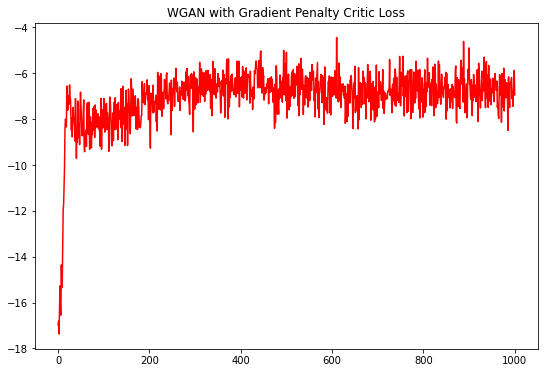

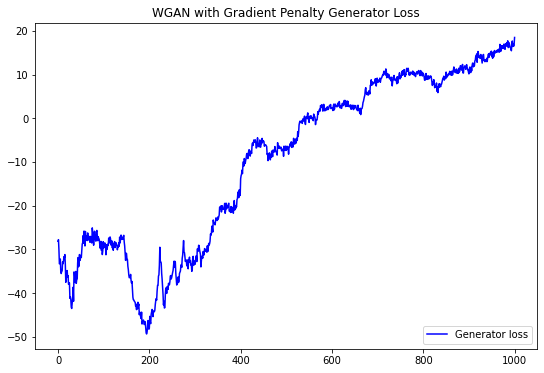

In [5]:
family = ['AllFiveFamilies']
for fam in family:
  print('Current family: %s' % (fam))
  data_obj = data.DATA(fam, 600)
  data_samples, num_unique = data_obj.load_data(True)
  gan = WGANGP(fam, num_unique, 10, 0.0001, 0.5, 0.9, True)
  f_d, ax_d, f_g, ax_g = gan.train(data_samples, num_unique, epochs=1001, batch_size=32, model_interval=500)
  plt.legend(loc='lower right')
  f_d.savefig('C:/Users/Albert/Desktop/CMPE_295/WGANGP_Results/Losses_conv1d/AllFiveFamilies_%s_critic.png'%(fam))
  f_g.savefig('C:/Users/Albert/Desktop/CMPE_295/WGANGP_Results/Losses_conv1d/AllFiveFamilies_%s_generator.png'%(fam))
  plt.show()